# Radiative Transfer : Non-LTE
---
What we have to solve is
$$
    S(\tau) = (1-\epsilon)\int_0^\infty S(\tau')K_1(|\tau'-\tau|)d\tau' + \epsilon B
$$
where
$$
\begin{align}
    K_1(s) &\equiv \frac{1}{2}\int_{-\infty}^{\infty}E_1(s\varphi_\nu)\varphi_\nu^2\varphi_{\nu,0}d\nu \\
    K_2(s) &\equiv \int_{-\infty}^{\infty}E_2(s\varphi_\nu)\varphi_\nu\varphi_{\nu,0}d\nu \\
    E_n(s) &\equiv \int_1^\infty \frac{e^{-st}}{t^n}dt \\
    \varphi_\nu &\equiv \frac{\phi_\nu}{\phi_{\nu,0}}
\end{align}
$$
and the integral of $K_1(s)$ is obtained by $K_2(s)$.
$$
    \int_0^s K_1(s')ds' = \frac{1}{2}(1-K_2(s))
$$
The line profile $\phi_\nu$ can be Gaussian profile, Lorentzian profile, and Voigt profile.
$$
\begin{align}
    \phi_\nu^G &= \frac{1}{\sqrt{\pi}\Delta\nu_D}\exp(-(\frac{\nu-\nu_0}{\Delta\nu_D})^2) = \frac{1}{\sqrt{\pi}\Delta\nu_D}\exp(-u^2) \\
    \phi_\nu^L &= \frac{\gamma/4\pi^2}{(\nu-\nu_0)^2+(\gamma/4\pi)^2} = \frac{1}{\sqrt{\pi}\Delta\nu_D}\frac{a/\sqrt{\pi}}{u^2+a^2} \\
    \phi_\nu^V &= \phi_\nu^G*\phi_\nu^L = \frac{1}{\sqrt{\pi}\Delta\nu_D}H(u,a) = \frac{1}{\sqrt{\pi}\Delta\nu_D}\frac{a}{\pi}\int \frac{\exp(-u'^2)}{(u-u'^2)+a^2}du'
\end{align}
$$
where
$$
\begin{align}
    \Delta\nu_D &= \frac{\nu_0}{c}\sqrt{\frac{2kT}{M}+\xi^2} \\
    a &= \frac{\gamma}{4\pi\Delta\nu_D}
\end{align}
$$

In [1]:
# FUNDMENTAL SETTING
# INTERNAL MODULES
from time import time
import multiprocessing as mp
from multiprocessing import Pool, Process, Queue, Manager

# NUMPY, MATPLOTLIB, SCIPY MODULES
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors
import scipy.special as special
from scipy.special import expn
from scipy.special import wofz
from scipy import integrate, interpolate

# ADDINTIONAL MODULES


# LOCAL MODULES


# CONFIGURATION
%config InlineBackend.figure_format='retina'
#%matplotlib inline

plt.rcParams['font.size'] = 15
plt.rc('legend', fontsize=12)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
#plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True

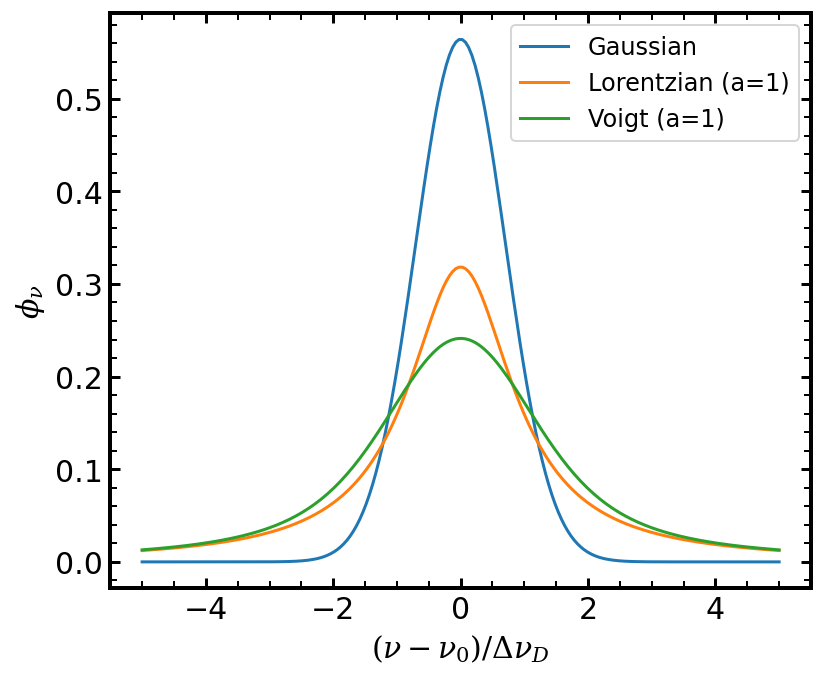

In [2]:
# LINE PROFILES
# dx : doppler broadening width, delta nu_D
# ga : damping strength, gamma/(4*pi)

class LineProfile:
    def __init__(self, dx=1, ga=1):
        self.dx = dx
        self.ga = ga
    
    def gaussian(self, x):
        return np.exp(-x**2/self.dx**2)/np.pi**0.5/self.dx
    
    def lorentzian(self, x):
        return (self.ga/np.pi)/(x**2+self.ga**2)
    
    def voigt(self, x):
        return special.voigt_profile(x, self.dx/2**0.5, self.ga)

# PLOT LINE PROFILE

x = np.linspace(-5,5,200)
line = LineProfile()

fig = plt.figure(figsize=(6,5))

plt.plot(x,line.gaussian(x), label='Gaussian')
plt.plot(x,line.lorentzian(x), label='Lorentzian (a=1)')
plt.plot(x,line.voigt(x), label='Voigt (a=1)')

plt.xlabel(r'$(\nu-\nu_0)/\Delta\nu_D$')
plt.ylabel(r'$\phi_\nu$')

plt.tick_params(direction='in', length=5)
#plt.grid(ls=':')
plt.legend()

fig.tight_layout()
#plt.savefig('line_profiles.pdf', format='pdf', dpi=1000)
plt.show()

In [3]:
# SPECIAL KERNEL FUNCTION
# a : damping parameter, = ga/dx = gamma/(4*pi*delta nu_D)
# default = modified special kernel function

class SpecialFunction():
    def __init__(self, dx=1, ga=1):
        self.dx = dx
        self.ga = ga
        self.a = ga/dx
        self.lines = LineProfile(dx,ga)
        
    def K1(self, tau, s='gaussain', modi=True):
        I = 0
        
        if s=='gaussian':
            self.line = self.lines.gaussian
            
        elif s=='lorentzian':
            self.line = self.lines.lorentzian
            
        elif s=='voigt':
            self.line = self.lines.voigt
        
        grand = lambda x: expn(1, tau*self.line(x)/self.line(0)) * self.line(x)**2 / self.line(0)
        
        if modi and tau > 1e5:
            I = integrate.quad(grand, 0, np.inf)[0]
        else:
            I = integrate.quad(grand, 0, np.inf)[0]
        
        return I
    
    def K2(self, tau, s='voigt', modi=True):
        I = 0
        
        if s=='gaussian':
            self.line = self.lines.gaussian
            
        elif s=='lorentzian':
            self.line = self.lines.lorentzian
            
        elif s=='voigt':
            self.line = self.lines.voigt
        
        grand = lambda x: expn(2, tau*self.line(x)/self.line(0)) * self.line(x)
        grand1 = lambda x: expn(2, 1e5*self.line(x)/self.line(0)) * self.line(x)
        
        if modi and tau > 1e5:
            I = integrate.quad(grand1, 0, np.inf)[0]
            
            if s=='gaussian':
                I = (1e5*np.log(1e5/np.pi**0.5)**0.5)/(tau*np.log(tau/np.pi**0.5)**0.5)*I
            elif s=='lorentzian' or s=='voigt':
                I = (1e5/tau)**0.5*I
        else:
            I = integrate.quad(grand, 0, np.inf)[0]
    
        return 2*I

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The integral is proba

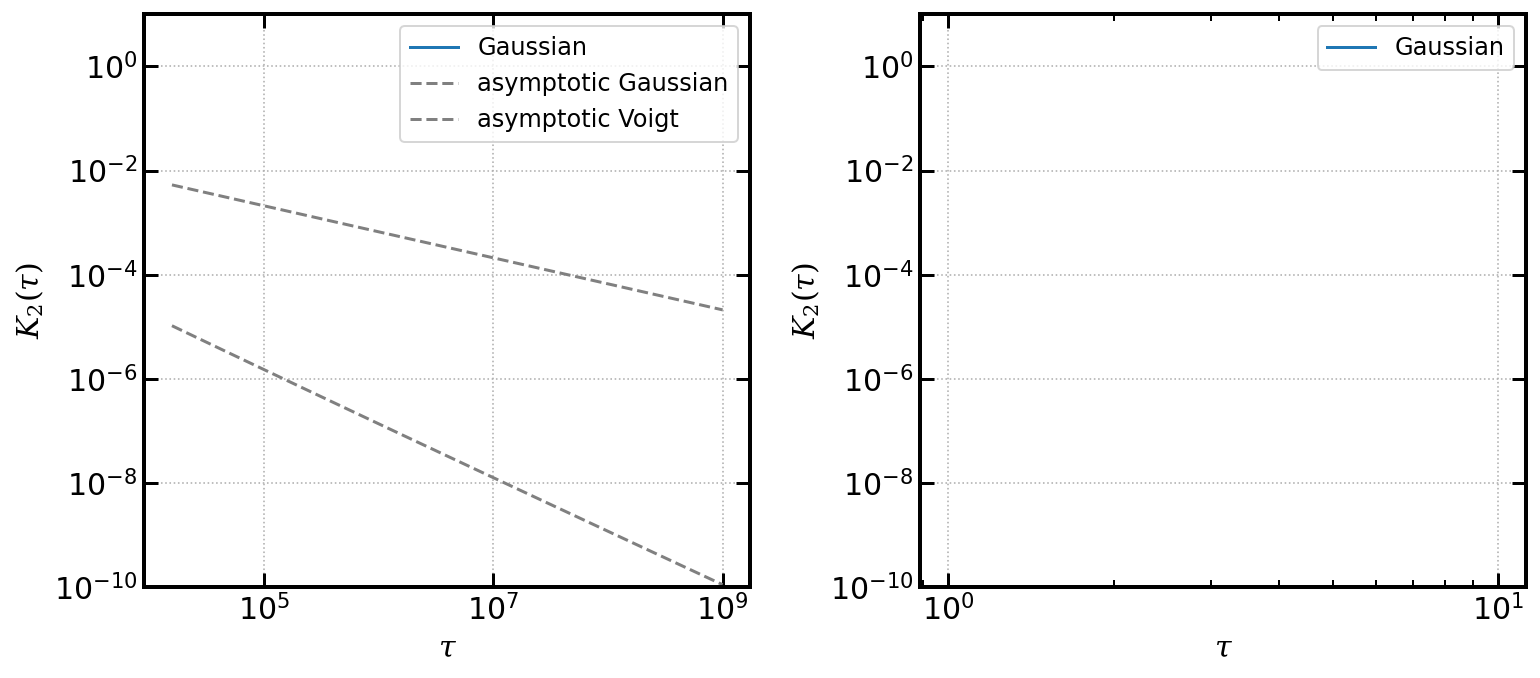

In [25]:
# PLOT THE FUNCTION
tau = np.logspace(-9,9,151)
spf = SpecialFunction()

g, l, v = [], [], []
for t in tau:
    g.append(spf.K1(t,'gaussian', False))
    l.append(spf.K1(t,'lorentzian', False))
    v.append(spf.K1(t,'voigt', False))

fig, ax = plt.subplots(1,2, figsize=(11,5))

ax[0].plot(tau,g, label='Gaussian')
# ax[0].plot(tau,l, label='Lorentzian (a={:.0f})'.format(spf.a))
# ax[0].plot(tau,v, label='Voigt (a={:.0f})'.format(spf.a))

asym_g = lambda x: 1/(2*x*np.log(x/np.pi**0.5)**0.5)
asym_v = lambda x: 2/(3*x**0.5)
ax[0].plot(tau[110:], asym_g(tau[110:]), color='gray', linestyle='--', label='asymptotic Gaussian')
ax[0].plot(tau[110:], asym_v(tau[110:]), color='gray', linestyle='--', label='asymptotic Voigt')

ax[0].set(xscale='log', yscale='log', xlabel=r'$\tau$', ylabel=r'$K_2(\tau)$', ylim=(1e-10,1e1))
ax[0].grid(ls=':')
ax[0].legend()

gn, ln, vn = [], [], []
for t in tau:
    gn.append(spf.K1(t,'gaussian', True))
    ln.append(spf.K1(t,'lorentzian', True))
    vn.append(spf.K1(t,'voigt', True))
    
ax[1].plot(tau, gn, label='Gaussian')
# ax[1].plot(tau, ln, label='Lorentzian (a={:.0f})'.format(spf.a))
# ax[1].plot(tau, vn, label='Voigt (a={:.0f})'.format(spf.a))

ax[1].set(xscale='log', yscale='log', xlabel=r'$\tau$', ylabel=r'$K_2(\tau)$', ylim=(1e-10,1e1))
ax[1].grid(ls=':')
ax[1].legend()

fig.tight_layout()
#plt.savefig('kernel_function.pdf', format='pdf', dpi=1000)
plt.show()

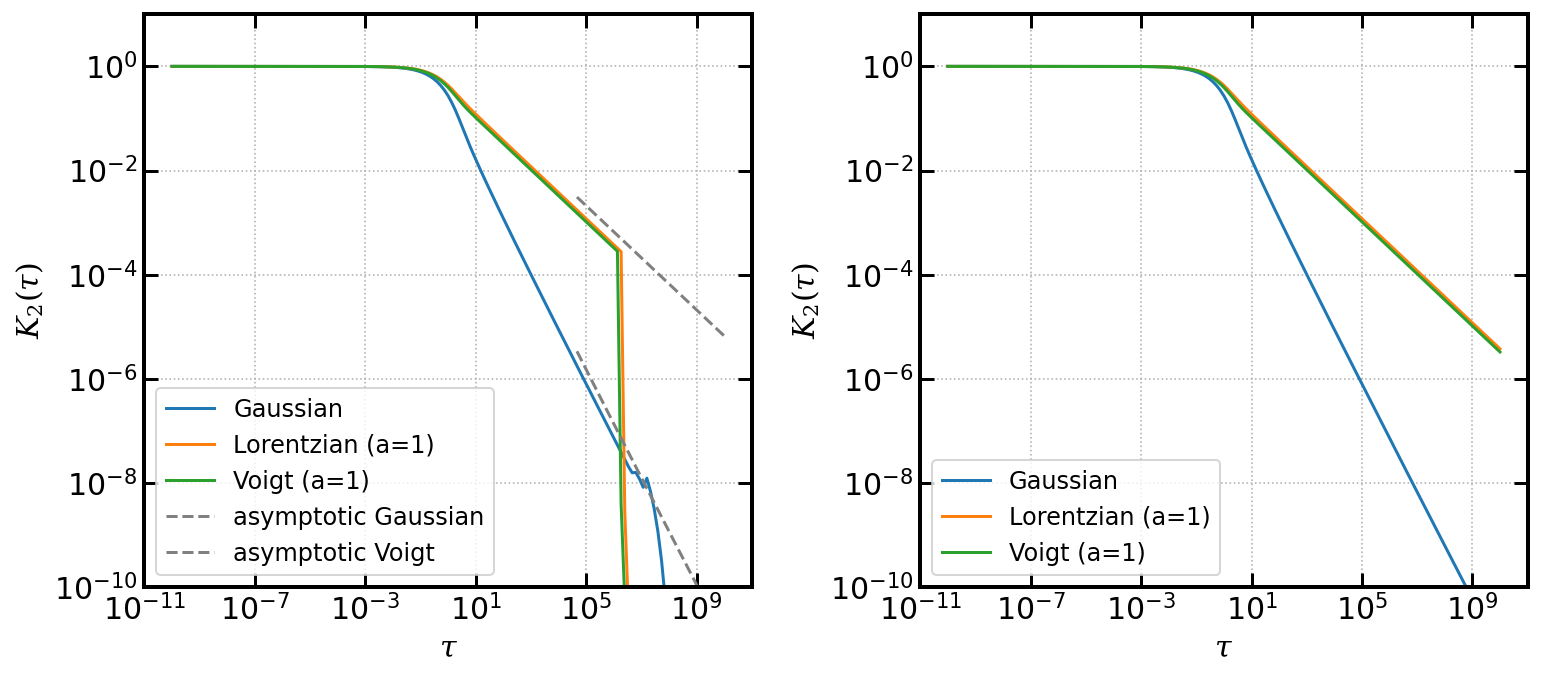

In [4]:
# PLOT THE FUNCTION
tau = np.logspace(-10,10,151)
spf = SpecialFunction()

g, l, v = [], [], []
for t in tau:
    g.append(spf.K2(t,'gaussian', False))
    l.append(spf.K2(t,'lorentzian', False))
    v.append(spf.K2(t,'voigt', False))

fig, ax = plt.subplots(1,2, figsize=(11,5))

ax[0].plot(tau,g, label='Gaussian')
ax[0].plot(tau,l, label='Lorentzian (a={:.0f})'.format(spf.a))
ax[0].plot(tau,v, label='Voigt (a={:.0f})'.format(spf.a))

asym_g = lambda x: 1/(2*x*np.log(x/np.pi**0.5)**0.5)
asym_v = lambda x: 2/(3*x**0.5)
ax[0].plot(tau[110:], asym_g(tau[110:]), color='gray', linestyle='--', label='asymptotic Gaussian')
ax[0].plot(tau[110:], asym_v(tau[110:]), color='gray', linestyle='--', label='asymptotic Voigt')

ax[0].set(xscale='log', yscale='log', xlabel=r'$\tau$', ylabel=r'$K_2(\tau)$', ylim=(1e-10,1e1))
ax[0].grid(ls=':')
ax[0].legend()

gn, ln, vn = [], [], []
for t in tau:
    gn.append(spf.K2(t,'gaussian', True))
    ln.append(spf.K2(t,'lorentzian', True))
    vn.append(spf.K2(t,'voigt', True))
    
ax[1].plot(tau, gn, label='Gaussian')
ax[1].plot(tau, ln, label='Lorentzian (a={:.0f})'.format(spf.a))
ax[1].plot(tau, vn, label='Voigt (a={:.0f})'.format(spf.a))

ax[1].set(xscale='log', yscale='log', xlabel=r'$\tau$', ylabel=r'$K_2(\tau)$', ylim=(1e-10,1e1))
ax[1].grid(ls=':')
ax[1].legend()

fig.tight_layout()
#plt.savefig('kernel_function.pdf', format='pdf', dpi=1000)
plt.show()

## $\Lambda$-iteration, accelerated $\Lambda$-iteration, and exact solution
---
$\Lambda$-iteration is written by
$$
    S = (1-\epsilon)\Lambda[S^\dagger] + \epsilon B
$$
and accelerated $\Lambda$-iteration is written as
$$
    S = \frac{(1-\epsilon)(\Lambda-\Lambda^*)[S^\dagger]+\epsilon B}{1-(1-\epsilon)\Lambda^*}
$$
but it can be exactly solved using its inverse matrix,
$$
    S = (1-(1-\epsilon)\Lambda)^{-1}\epsilon B
$$

In [5]:
# GENERATE LAMBDA MATRIX
def LAMBDA(N, a=0, s=''):
    t = np.logspace(-5,9,N)
    lamb = np.zeros((N,N))
    K2 = SpecialFunction(dx=1,ga=a).K2

    for j in range(N):
        for i in range(N):
            if j==0:
                s2 = (t[j]+t[j+1])/2 - t[i]
                s1 = (3*t[j]-t[j+1])/2 - t[i]
            elif j==N-1:
                s2 = (3*t[j]-t[j-1])/2 - t[i]
                s1 = (t[j]+t[j-1])/2 - t[i]
            else:
                s2 = (t[j]+t[j+1])/2 - t[i]
                s1 = (t[j]+t[j-1])/2 - t[i] 
        
            if s1>=0 and s2>=0:
                lamb[i][j] = (K2(s1,s)-K2(s2,s))/2
            elif s1<0 and s2>=0:
                lamb[i][j] = 1-(K2(s2,s)+K2(-s1,s))/2
            elif s1<0 and s2<0:
                lamb[i][j] = (K2(-s2,s)-K2(-s1,s))/2
    
    print('LAMBDA matrix are prepared.')
    return lamb

In [6]:
lamb = LAMBDA(100, a=0, s='gaussian')

LAMBDA matrix are prepared.


In [22]:
lamb[-2,-1]

1.5072566918080297e-10

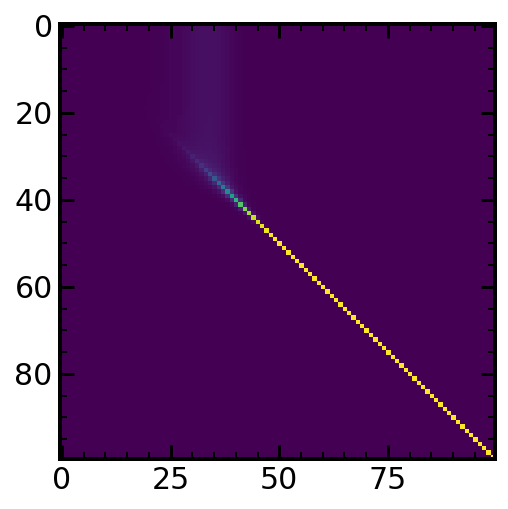

In [26]:
plt.imshow(lamb)

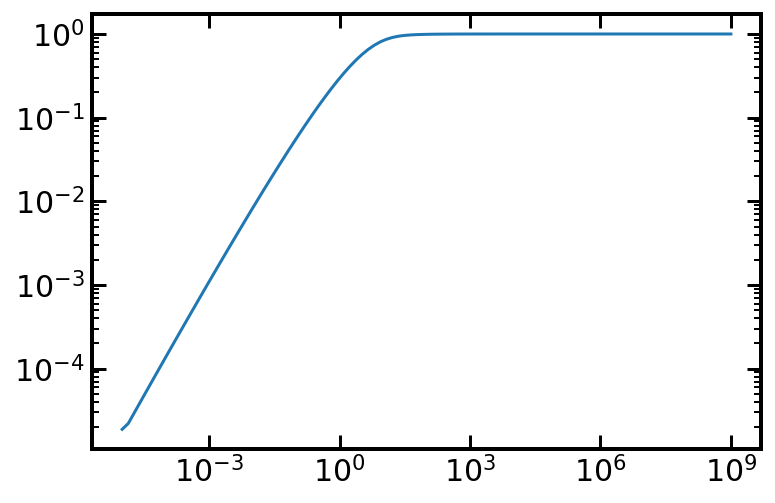

In [20]:
plt.loglog(np.logspace(-5,9,100), np.diag(lamb))
# plt.yscale('log')
# plt.xlim(1, 1e3)
# plt.ylim(0.1, 1)

LAMBDA matrix are prepared.


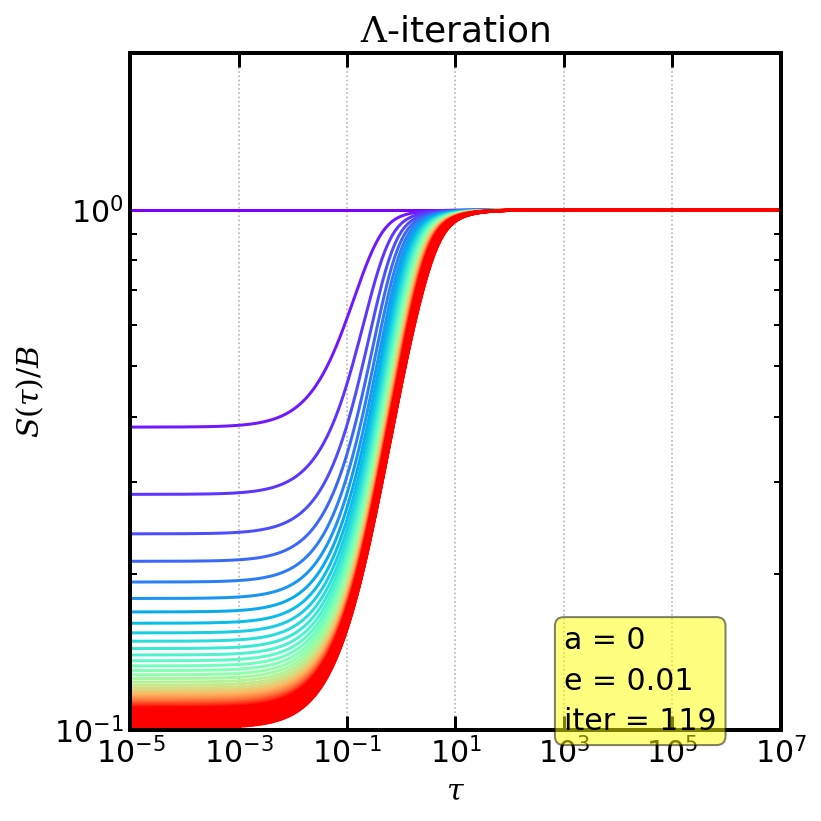

In [9]:
# LAMBDA-ITERATION & PLOT
N = 200
tau = np.logspace(-5,7,N)
S = np.ones(N)
a = 0
e = 1e-2
lamb = LAMBDA(N,a,'gaussian')
i = 0
    
fig, ax = plt.subplots(1,1,figsize=(6,6))
font_txt = {'size':15,'linespacing':1.5}

while S[0]-e**0.5 > e**0.5/100:
    if i%2 == 0:
        ax.loglog(tau,S, color=plt.cm.rainbow(i/60))
    S = (1-e)*lamb@S + e
    i += 1
    
ax.text(1e3,e**0.5, 'a = {}\ne = {}\niter = {}'.format(a,e,i),
        **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})

ax.set(title=r'$\Lambda$-iteration', xlabel=r'$\tau$', ylabel=r'$S(\tau)/B$', 
       xlim=(1e-5,1e7), ylim=(e**0.5/2, 2))
ax.grid(ls=':')

fig.tight_layout()
#plt.savefig('lambda-iteration_(0,1e-2).pdf', format='pdf', dpi=1000)
plt.show()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


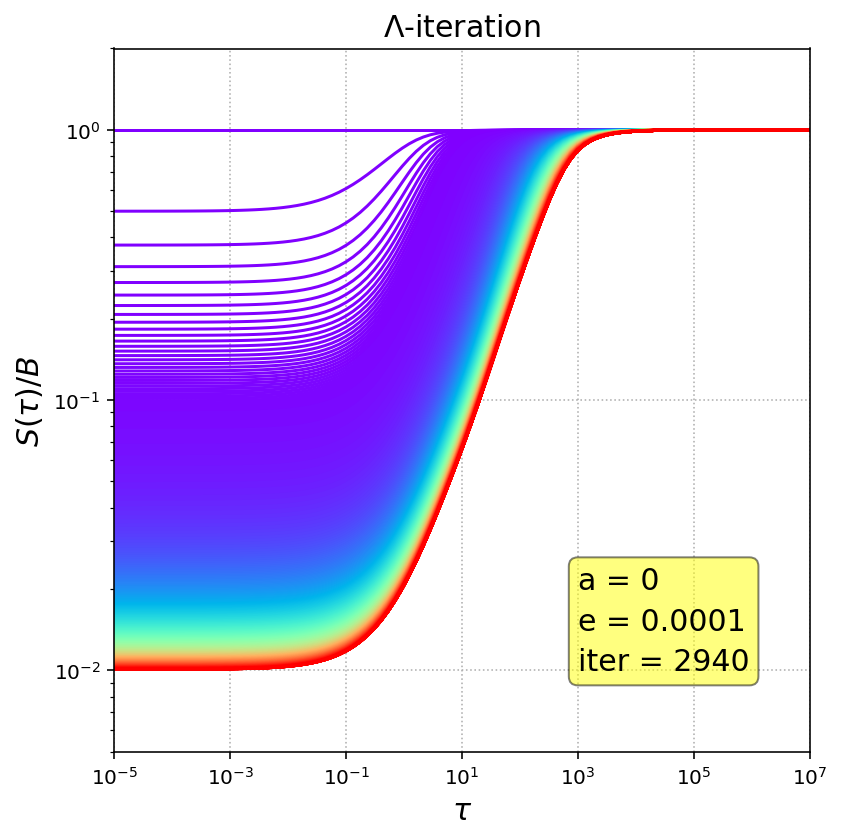

In [57]:
# LAMBDA-ITERATION & PLOT
N = 100
tau = np.logspace(-5,7,N)
S = np.ones(N)
a = 0
e = 1e-4
lamb = LAMBDA(N,a)
i = 0
    
fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_all = {'size':15}
font_txt = {'size':15,'linespacing':1.5}

while S[0]-e**0.5 > e**0.5/100:
    ax.loglog(tau,S, color=plt.cm.rainbow(i/2940))
    S = (1-e)*lamb@S + e
    i += 1
    if i%100==0:
        print(i)
    
ax.text(1e3,e**0.5, 'a = {}\ne = {}\niter = {}'.format(a,e,i),
        **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title(r'$\Lambda$-iteration',**font_all)
ax.set_xlabel(r'$\tau$',**font_all)
ax.set_ylabel(r'$S(\tau)/B$',**font_all)
ax.set_xlim(1e-5,1e7)
ax.set_ylim(e**0.5/2,2)
ax.grid(ls=':')

fig.tight_layout()
#plt.savefig('lambda-iteration_(0,1e-4).pdf', format='pdf', dpi=1000)
plt.show()

## Accelerated $\Lambda$-iteration
---
$$
    S = \frac{(1-\epsilon)(\Lambda-\Lambda^*)[S^\dagger]+\epsilon B}{1-(1-\epsilon)\Lambda^*}
$$

LAMBDA matrix are prepared.


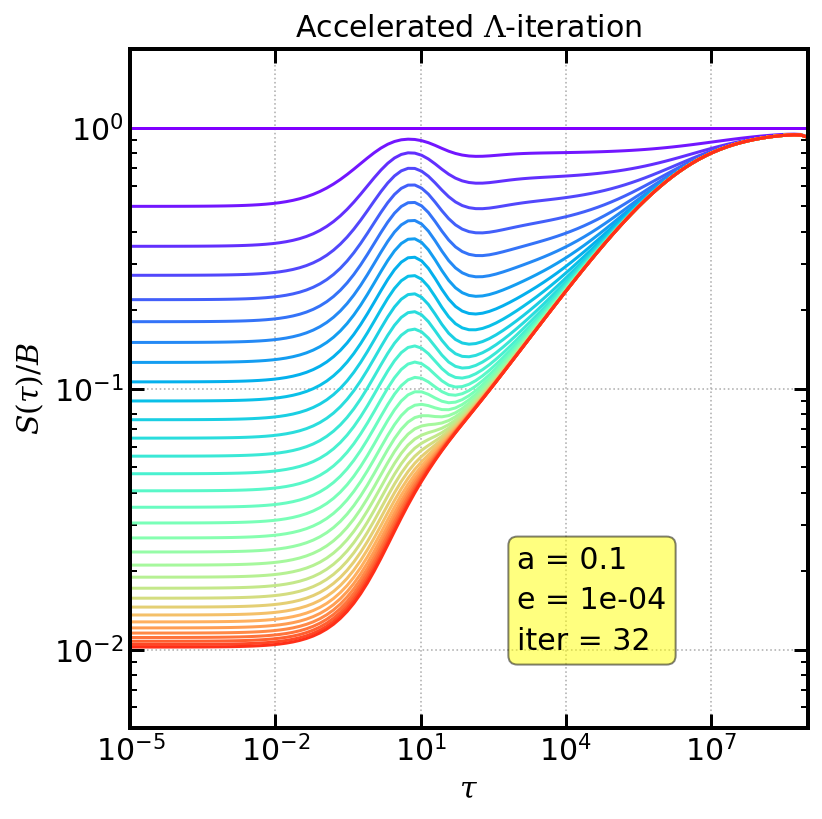

In [12]:
# LAMBDA-ITERATION & PLOT
N = 101
tau = np.logspace(-5,9,N)
S = np.ones(N)
a = 0.1
e = 1e-4
lamb = LAMBDA(N,a, 'voigt')
lamb_diag = np.diag(lamb.diagonal())
i = 0
    
fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_all = {'size':15}
font_txt = {'size':15,'linespacing':1.5}

while S[0]-e**0.5 > e**0.5/100:
    ax.loglog(tau,S, color=plt.cm.rainbow(i/33))
    S = (1-e)*(lamb-lamb_diag)@S + e
    S = np.linalg.inv(np.eye(N)-(1-e)*lamb_diag)@S
    i += 1
    
ax.text(1e3,e**0.5, 'a = {}\ne = {:.0e}\niter = {}'.format(a,e,i),
        **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title(r'Accelerated $\Lambda$-iteration',**font_all)
ax.set_xlabel(r'$\tau$',**font_all)
ax.set_ylabel(r'$S(\tau)/B$',**font_all)
ax.set_xlim(1e-5,1e9)
ax.set_ylim(e**0.5/2,2)
ax.grid(ls=':')

fig.tight_layout()
plt.savefig('lambda-iteration_acc_({},{:.0e}).pdf'.format(a,e), format='pdf', dpi=1000)
plt.show()

## Direct Matrix Calculation
---
$$
    S = (1-(1-\epsilon)\Lambda)^{-1}\epsilon B
$$

LAMBDA matrix are prepared.


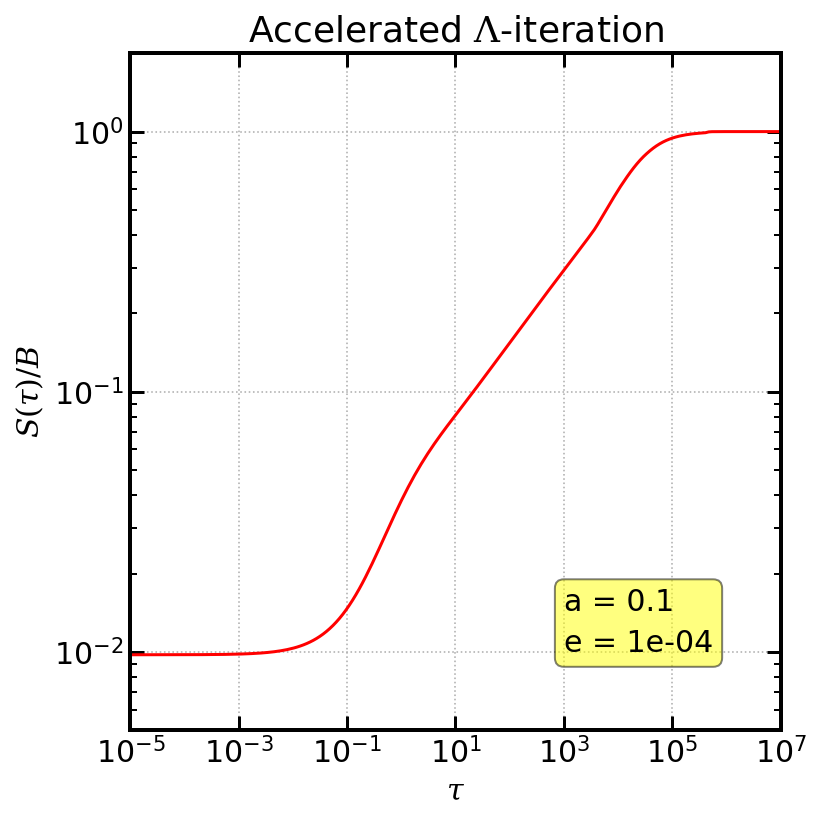

In [46]:
# LAMBDA-ITERATION & PLOT
N = 200
tau = np.logspace(-5,7,N)
S = np.ones(N)
a = 0.1
e = 1e-4
lamb = LAMBDA(N,a,s='voigt')

S = np.linalg.inv(np.eye(N)-(1-e)*lamb)@S*e
    
fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_txt = {'size':15,'linespacing':1.5}

ax.loglog(tau,S, color='red')
    
ax.text(1e3,e**0.5, 'a = {}\ne = {:.0e}'.format(a,e),
        **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title(r'Accelerated $\Lambda$-iteration')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$S(\tau)/B$')
ax.set_xlim(1e-5,1e7)
ax.set_ylim(e**0.5/2,2)
ax.grid(ls=':')

fig.tight_layout()
plt.savefig('lambda-iteration_dmc_({},{:.0e}).pdf'.format(a,e), format='pdf', dpi=1000)
plt.show()

LAMBDA matrix are prepared.
LAMBDA matrix are prepared.
LAMBDA matrix are prepared.
LAMBDA matrix are prepared.


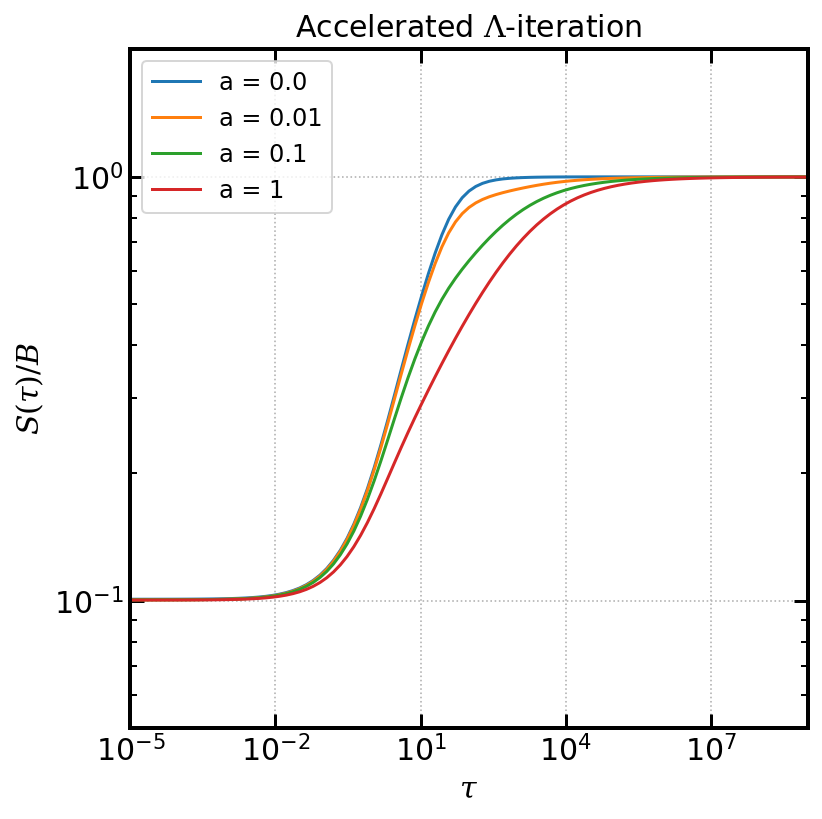

In [17]:
# LAMBDA-ITERATION & PLOT
N = 101
tau = np.logspace(-5,9,N)
a = [0., 1e-2, 1e-1, 1]
e = 1e-2

fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_all = {'size':15}
font_txt = {'size':15,'linespacing':1.5}

for aa in a:
    S = np.ones(N)
    lamb = LAMBDA(N,aa, 'voigt')
    lamb_diag = np.diag(lamb.diagonal())
    i = 0
    
    while S[0]-e**0.5 > e**0.5/100:
        S = (1-e)*(lamb-lamb_diag)@S + e
        S = np.linalg.inv(np.eye(N)-(1-e)*lamb_diag)@S
        i += 1
    
    ax.loglog(tau,S, label=f'a = {aa}')
    
# ax.text(1e3,e**0.5, 'a = {}\ne = {:.0e}\niter = {}'.format(a,e,i),
#         **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title(r'Accelerated $\Lambda$-iteration',**font_all)
ax.set_xlabel(r'$\tau$',**font_all)
ax.set_ylabel(r'$S(\tau)/B$',**font_all)
ax.set_xlim(1e-5,1e9)
ax.set_ylim(e**0.5/2,2)
ax.grid(ls=':')
ax.legend()

fig.tight_layout()
plt.savefig('lambda-iteration_acc_({},{:.0e}).pdf'.format(a,e), format='pdf', dpi=1000)
plt.show()

LAMBDA matrix are prepared.
LAMBDA matrix are prepared.
LAMBDA matrix are prepared.
LAMBDA matrix are prepared.


TypeError: unsupported format string passed to list.__format__

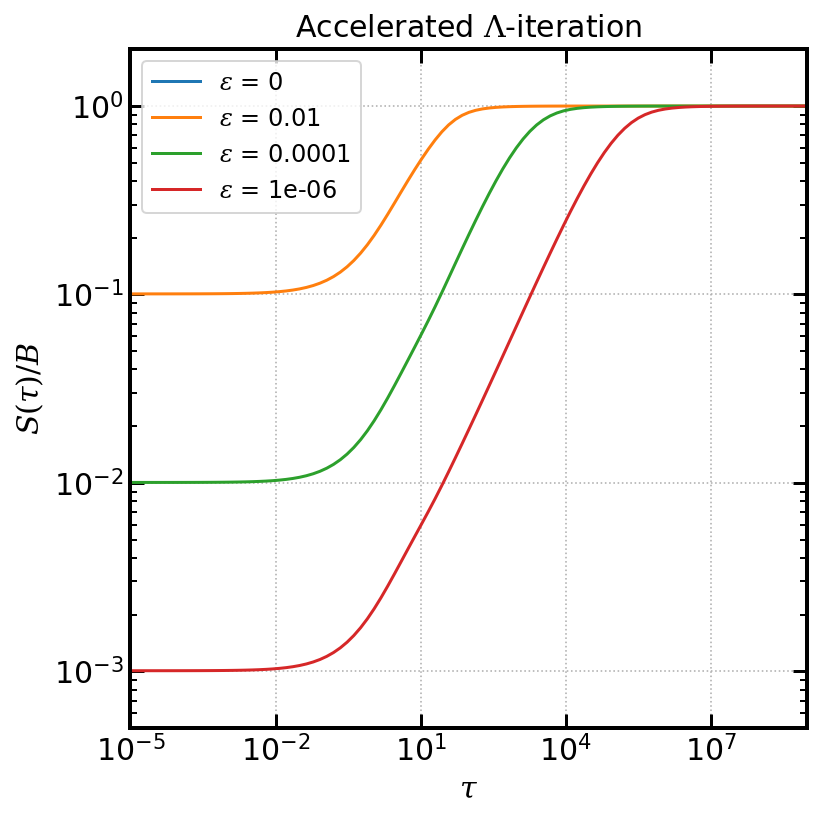

In [19]:
# LAMBDA-ITERATION & PLOT
N = 101
tau = np.logspace(-5,9,N)
a = 0
e = [0, 1e-2, 1e-4, 1e-6]

fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_all = {'size':15}
font_txt = {'size':15,'linespacing':1.5}

for ee in e:
    S = np.ones(N)
    lamb = LAMBDA(N, a, 'gaussian')
    lamb_diag = np.diag(lamb.diagonal())
    i = 0
    
    while S[0]-ee**0.5 > ee**0.5/100:
        S = (1-ee)*(lamb-lamb_diag)@S + ee
        S = np.linalg.inv(np.eye(N)-(1-ee)*lamb_diag)@S
        i += 1
    
    ax.loglog(tau,S, label=rf'$\epsilon$ = {ee}')
    
# ax.text(1e3,e**0.5, 'a = {}\ne = {:.0e}\niter = {}'.format(a,e,i),
#         **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title(r'Accelerated $\Lambda$-iteration',**font_all)
ax.set_xlabel(r'$\tau$',**font_all)
ax.set_ylabel(r'$S(\tau)/B$',**font_all)
ax.set_xlim(1e-5,1e9)
ax.set_ylim(1e-3/2,2)
ax.grid(ls=':')
ax.legend()

fig.tight_layout()
plt.savefig('lambda-iteration_acc_({},{:.0e}).pdf'.format(a,e), format='pdf', dpi=1000)
plt.show()

## Comparison btw. methods
---


LAMBDA matrix are prepared.
LAMBDA matrix set
S1 done
S2 done
S3 done


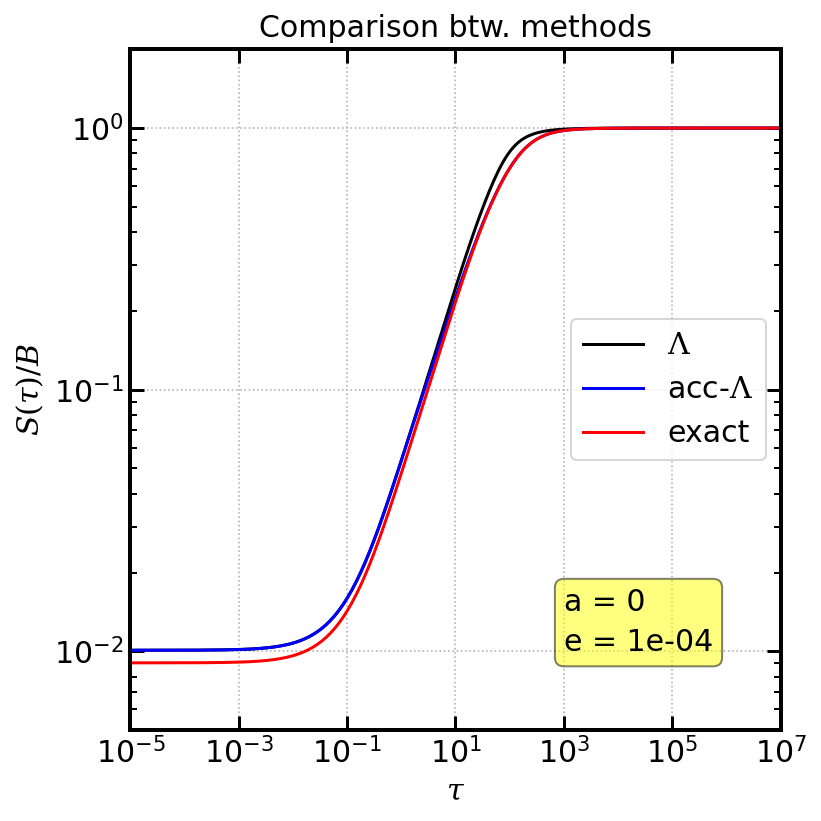

In [13]:
# LAMBDA-ITERATION
N = 300
tau = np.logspace(-5,7,N)
S = np.ones(N)
a = 0
e = 1e-4
lamb = LAMBDA(N,a, 'gaussian')
lamb_diag = np.diag(lamb.diagonal())
print('LAMBDA matrix set')

S1 = S
while S1[0]-e**0.5 > e**0.5/100:
    S1 = (1-e)*lamb@S1 + e
print('S1 done')
    
S2 = S
A = (1-e)*(lamb-lamb_diag)
B = np.linalg.inv(np.eye(N)-(1-e)*lamb_diag)
while S2[0]-e**0.5 > e**0.5/100:
    S2 = A@S2 + e
    S2 = B@S2
print('S2 done')
    
S3 = np.linalg.inv(np.eye(N)-(1-e)*lamb)@S*e
print('S3 done')
    
# PLOT
fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_all = {'size':15}
font_txt = {'size':15,'linespacing':1.5}

ax.loglog(tau,S1, color='black', label=r'$\Lambda$')
ax.loglog(tau,S2, color='blue', label=r'acc-$\Lambda$')
ax.loglog(tau,S3, color='red', label='exact')
    
ax.text(1e3,e**0.5, 'a = {}\ne = {:.0e}'.format(a,e),
        **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title('Comparison btw. methods',**font_all)
ax.set_xlabel(r'$\tau$',**font_all)
ax.set_ylabel(r'$S(\tau)/B$',**font_all)
ax.set_xlim(1e-5,1e7)
ax.set_ylim(e**0.5/2,2)
ax.grid(ls=':')
ax.legend(loc='center right',fontsize=15)

fig.tight_layout()
plt.savefig('lambda-iteration_tot_({},{:.0e}).pdf'.format(a,e), format='pdf', dpi=1000)
plt.show()

In [131]:
# MODIFIED SPECIAL KERNEL FUNCTION
def K2_(tau,a=0,s=''):
    I = 0
    dx = 1
    g = dx*a
    expn = special.expn
    
    if a==0:
        line = gaussian
        if tau > 1e5:
            I = integrate.quad(lambda x: expn(2,1e5*line(x,dx)/line(0,dx))*line(x,dx), 0, np.inf)[0]
            I = (1e5*np.log(1e5/np.pi**0.5)**0.5)/(tau*np.log(tau/np.pi**0.5)**0.5)*I
        else:
            I = integrate.quad(lambda x: expn(2,tau*line(x,dx)/line(0,dx))*line(x,dx), 0, np.inf)[0]
        
    elif s=='lorentzian':
        line = lorentzian
        I = integrate.quad(lambda x: expn(2,tau*line(x,g)/line(0,g))*line(x,g), 0, np.inf)[0]
        
    else:
        line = voigt
        if tau > 1e5:
            I = integrate.quad(lambda x: expn(2,1e5*line(x,dx,g)/line(0,dx,g))*line(x,dx,g), 0, np.inf)[0]
            I = (1e5/tau)**0.5*I
        else:
            I = integrate.quad(lambda x: expn(2,tau*line(x,dx,g)/line(0,dx,g))*line(x,dx,g), 0, np.inf)[0]
    
    return 2*I

# GENERATE MODIFIED LAMBDA MATRIX
def LAMBDA_(N,a=0,s=''):
    t = np.logspace(-5,9,N)
    lamb = np.zeros((N,N))

    for j in range(N):
        for i in range(N):
            if j==0:
                s2 = (t[j]+t[j+1])/2 - t[i]
                s1 = t[j] - t[i]
            elif j==N-1:
                s2 = (3*t[j]-t[j-1])/2 - t[i]
                s1 = (t[j]+t[j-1])/2 - t[i]
            else:
                s2 = (t[j]+t[j+1])/2 - t[i]
                s1 = (t[j]+t[j-1])/2 - t[i] 
        
            if s1>=0 and s2>=0:
                lamb[i][j] = (K2_(s1,a,s)-K2_(s2,a,s))/2
            elif s1<0 and s2>=0:
                lamb[i][j] = 1-(K2_(s2,a,s)+K2_(-s1,a,s))/2
            elif s1<0 and s2<0:
                lamb[i][j] = (K2_(-s2,a,s)-K2_(-s1,a,s))/2
                
    return lamb

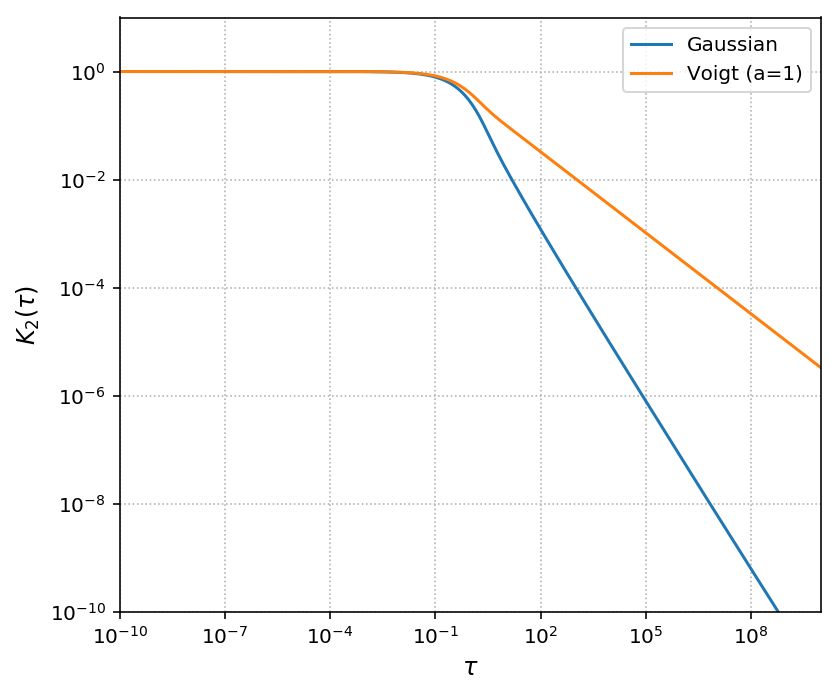

In [123]:
# PLOT THE FUNCTION
tau = np.logspace(-10,10,200)
a = 1
g, v = [], []
for t in tau:
    g.append(K2_(t,0,'gaussian'))
    v.append(K2_(t,a,'voigt'))

fig = plt.figure(figsize=(6,5))
font_axis = {'size':12}

plt.loglog(tau,g, label='Gaussian')
plt.loglog(tau,v, label='Voigt (a={})'.format(a))

plt.xlabel(r'$\tau$',**font_axis)
plt.ylabel(r'$K_2(\tau)$',**font_axis)
plt.xlim(10**-10,10**10)
plt.ylim(10**-10,10**1)
plt.grid(ls=':')
plt.legend()

fig.tight_layout()
#plt.savefig('kernel_function.pdf', format='pdf', dpi=1000)
plt.show()

LAMBDA matrix set
S1 done
S2 done
S3 done


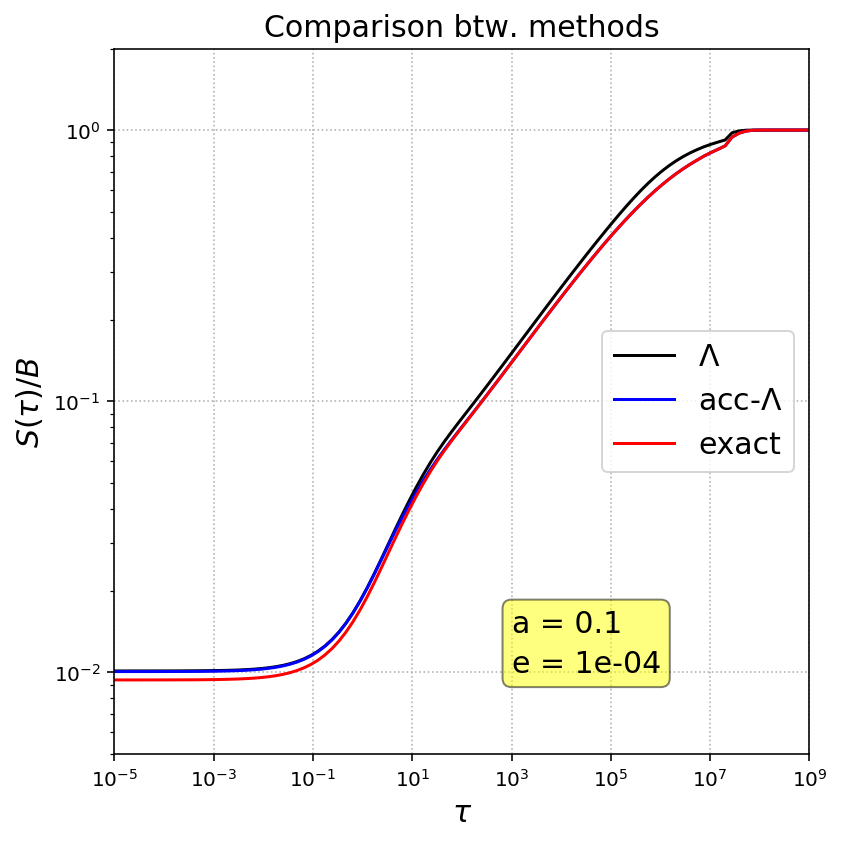

In [132]:
# LAMBDA-ITERATION
N = 100
tau = np.logspace(-5,9,N)
S = np.ones(N)
a = 0.1
e = 1e-4
#lamb = LAMBDA_(N,a)
lamb_diag = np.diag(lamb.diagonal())
print('LAMBDA matrix set')

S1 = S
while S1[0]-e**0.5 > e**0.5/100:
    S1 = (1-e)*lamb@S1 + e
print('S1 done')
    
S2 = S
A = (1-e)*(lamb-lamb_diag)
B = np.linalg.inv(np.eye(N)-(1-e)*lamb_diag)
while S2[0]-e**0.5 > e**0.5/100:
    S2 = A@S2 + e
    S2 = B@S2
print('S2 done')
    
S3 = np.linalg.inv(np.eye(N)-(1-e)*lamb)@S*e
print('S3 done')
    
# PLOT
fig, ax = plt.subplots(1,1,figsize=(6,6))    
font_all = {'size':15}
font_txt = {'size':15,'linespacing':1.5}

ax.loglog(tau,S1, color='black', label=r'$\Lambda$')
ax.loglog(tau,S2, color='blue', label=r'acc-$\Lambda$')
ax.loglog(tau,S3, color='red', label='exact')
    
ax.text(1e3,e**0.5, 'a = {}\ne = {:.0e}'.format(a,e),
        **font_txt,bbox={'facecolor':'yellow','alpha':0.5,'boxstyle':'round'})
    
ax.set_title('Comparison btw. methods',**font_all)
ax.set_xlabel(r'$\tau$',**font_all)
ax.set_ylabel(r'$S(\tau)/B$',**font_all)
ax.set_xlim(1e-5,1e9)
ax.set_ylim(e**0.5/2,2)
ax.grid(ls=':')
ax.legend(loc='center right',fontsize=15)

fig.tight_layout()
plt.savefig('lambda-iteration_moditot_({},{:.0e}).pdf'.format(a,e), format='pdf', dpi=1000)
plt.show()